In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33783")
client

Client Scheduler: tcp://127.0.0.1:33783 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 70 Memory: 296.33 GB


In [2]:
import numpy as np
import xarray as xr
import gsw
import time
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import scipy.sparse as spar
import scipy.signal as spsig
import scipy.ndimage as spimg
import dask_image.ndfilters as dsfilt
import dask.array as dsar
import xrft
import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'

In [4]:
year = 1964

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50
sstart = 13
send = 34
nremap = 50
dnf = 2160
nchk = 30
nhskip = 3
nbskip = 2

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
# for nmemb in range(24,36):
#     if nmemb == 24:
#         ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                      % (nmemb,year)), 
#                              grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                              iters=943920,
#                              prefix=['diag_ocnSnap'], delta_t=2e2,
#                             ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                  ).chunk({'XC':xchunk,'XG':xchunk,
#                                           'YC':ychunk,'YG':ychunk})
#     else:
#         ds = xr.concat([ds, open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                                     % (nmemb,year)), 
#                                             grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
#                                             iters=943920,
#                                             prefix=['diag_ocnSnap'], delta_t=2e2,
#                                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                                 ).chunk({'XC':xchunk,'XG':xchunk,
#                                                          'YC':ychunk,'YG':ychunk})],
#                        dim='nmemb')
# ds = ds.isel(time=slice(-len(dsmn.time),None))
# pot_rho = xr.apply_ufunc(jmd95.densjmd95, ds.SALT.mean('nmemb'), ds.THETA.mean('nmemb'),
#                          0., # pressure in [dbar]!!!!
#                          dask='parallelized', output_dtypes=[float,]
#                         ).where(ds.maskC!=0.)
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (24,1963)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=943920,
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(yNstart-5-12**-1,yend+2*12**-1),
                          YG=slice(yNstart-5-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 483, YG: 483, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 1.888e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 9.916701 10.000034 10.083367 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) >f4 9.958367 10.041701 10.125034 ... 50.041702 50.125034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1      (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu       (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl       (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAz      (YG, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    drC      (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF   (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    PHIHYD   (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
def _dot(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
    return np.expand_dims(func, (0,1,2))

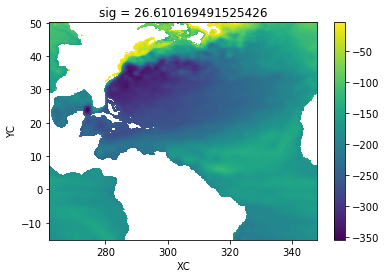

In [16]:
zetab.isel(sig=13).plot()

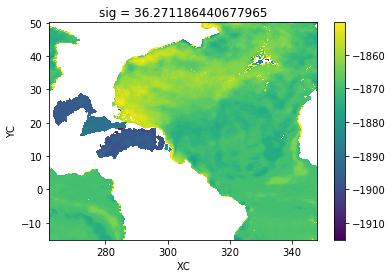

In [19]:
zetab.isel(sig=32).plot()

In [ ]:
G = xr.DataArray(np.array([[ tx_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200}), 
                             ty_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200})],
                           [ sx_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200}), 
                             sy_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200})],
                           [PVx_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200}),
                            PVy_norm.isel(YC=slice(None,12),XC=slice(None,10)).chunk({'sig':1,'YC':200,'XC':200})]]),
                 dims=['row','col','YC','XC','sig']
                ).transpose('sig','YC','XC','row','col')
# pinvG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
#                      dims=['sig','YC','XC','row','col'])
# pinvG
G

In [9]:
itime = 943920
# m = 10

for l in range(24,send):
    print('l =', l)
    m = l - sstart
    
    K = xr.DataArray(np.ones((len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),
                          len(dsz.XC),1,2,2))*np.nan,
                 dims=['YC','XC','sig','col','row'],
                 coords={'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).data,
                         'XC':dsz.XC.data,'sig':np.array([dsz.sig.isel(sig=l).data])}
                )
    

    for j in range(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)))):
        if j % 40 == 0:
            print('j =', j)
        for i in range(len(dsz.XC)):

            if i < len(dsz.XC)-1:
                k = i+1
            else:
                k = 0
            rowF  = np.array([ 0, 0, 
                               1, 1,
                               2, 2,
                               3, 3, 
                               4, 4,
                               5, 5,
                               6, 6, 
                               7, 7,
                               8, 8,
                               9, 9,
                              10,10,
                              11,11,
                              12,12,
                              13,13,
                              14,14])
            colF  = np.array([ 0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1])
            dataF = np.array([ ut_norm.isel(YC=j-1,XC=i,sig=m),  vt_norm.isel(YC=j-1,XC=i,sig=m),
                               us_norm.isel(YC=j-1,XC=i,sig=m),  vs_norm.isel(YC=j-1,XC=i,sig=m),
                              uPV_norm.isel(YC=j-1,XC=i,sig=m), vPV_norm.isel(YC=j-1,XC=i,sig=m),
                               ut_norm.isel(YC=j,XC=i,sig=m),    vt_norm.isel(YC=j,XC=i,sig=m),
                               us_norm.isel(YC=j,XC=i,sig=m),    vs_norm.isel(YC=j,XC=i,sig=m),
                              uPV_norm.isel(YC=j,XC=i,sig=m),   vPV_norm.isel(YC=j,XC=i,sig=m),
                               ut_norm.isel(YC=j+1,XC=i,sig=m),  vt_norm.isel(YC=j+1,XC=i,sig=m),
                               us_norm.isel(YC=j+1,XC=i,sig=m),  vs_norm.isel(YC=j+1,XC=i,sig=m),
                              uPV_norm.isel(YC=j+1,XC=i,sig=m), vPV_norm.isel(YC=j+1,XC=i,sig=m),
                               ut_norm.isel(YC=j,XC=i-1,sig=m),  vt_norm.isel(YC=j,XC=i-1,sig=m),
                               us_norm.isel(YC=j,XC=i-1,sig=m),  vs_norm.isel(YC=j,XC=i-1,sig=m),
                              uPV_norm.isel(YC=j,XC=i-1,sig=m), vPV_norm.isel(YC=j,XC=i-1,sig=m),
                               ut_norm.isel(YC=j,XC=k,sig=m),    vt_norm.isel(YC=j,XC=k,sig=m),
                               us_norm.isel(YC=j,XC=k,sig=m),    vs_norm.isel(YC=j,XC=k,sig=m),
                              uPV_norm.isel(YC=j,XC=k,sig=m),   vPV_norm.isel(YC=j,XC=k,sig=m)])
            F = spar.csr_matrix((dataF, (rowF, colF)), shape=(23,2)).toarray()

#################################
            rowG  = np.array([ 0, 0, 1, 1, 2, 2,
                               3, 3, 4, 4, 5, 5,
                               6, 6, 7, 7, 8, 8,
                               9, 9,10,10,11,11,
                              12,12,13,13,14,14,
                              15,15,15, 
                              16,16,16,
                              17,17,17, 
                              18,18,18,
                              19,19,19, 
                              20,20,20,
                              21,21,21, 
                              22,22,22])
            colG  = np.array([ 0, 3, 0, 3, 0, 3,
                               1, 4, 1, 4, 1, 4,
                               2, 5, 2, 5, 2, 5,
                               6, 8, 6, 8, 6, 8,
                               7, 9, 7, 9, 7, 9,
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9,    # B
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9])   # B
            wht = 1e3   # 1e6*1e-4
            Aj_1i = wht*(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Aji = wht*-dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                  + dyU.isel(YC=j,XG=i)**-1
                                                 )
            Aj1i = wht*(dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Bji_1 = wht*(dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1
            Bji = wht*-dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                + dxV.isel(YG=j,XC=i)**-1
                                               )
            Bji1 = wht*(dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1
            dataG = np.array([ -tx_norm.isel(YC=j-1,XC=i,sig=m),  -ty_norm.isel(YC=j-1,XC=i,sig=m),
                               -sx_norm.isel(YC=j-1,XC=i,sig=m),  -sy_norm.isel(YC=j-1,XC=i,sig=m),
                              -PVx_norm.isel(YC=j-1,XC=i,sig=m), -PVy_norm.isel(YC=j-1,XC=i,sig=m),
                               -tx_norm.isel(YC=j,XC=i,sig=m),    -ty_norm.isel(YC=j,XC=i,sig=m),
                               -sx_norm.isel(YC=j,XC=i,sig=m),    -sy_norm.isel(YC=j,XC=i,sig=m),
                              -PVx_norm.isel(YC=j,XC=i,sig=m),   -PVy_norm.isel(YC=j,XC=i,sig=m),
                               -tx_norm.isel(YC=j+1,XC=i,sig=m),  -ty_norm.isel(YC=j+1,XC=i,sig=m),
                               -sx_norm.isel(YC=j+1,XC=i,sig=m),  -sy_norm.isel(YC=j+1,XC=i,sig=m),
                              -PVx_norm.isel(YC=j+1,XC=i,sig=m), -PVy_norm.isel(YC=j+1,XC=i,sig=m),
                               -tx_norm.isel(YC=j,XC=i-1,sig=m),  -ty_norm.isel(YC=j,XC=i-1,sig=m),
                               -sx_norm.isel(YC=j,XC=i-1,sig=m),  -sy_norm.isel(YC=j,XC=i-1,sig=m),
                              -PVx_norm.isel(YC=j,XC=i-1,sig=m), -PVy_norm.isel(YC=j,XC=i-1,sig=m),
                               -tx_norm.isel(YC=j,XC=k,sig=m),    -ty_norm.isel(YC=j,XC=k,sig=m),
                               -sx_norm.isel(YC=j,XC=k,sig=m),    -sy_norm.isel(YC=j,XC=k,sig=m),
                              -PVx_norm.isel(YC=j,XC=k,sig=m),   -PVy_norm.isel(YC=j,XC=k,sig=m),
####################################                          
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1,
####################################
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1])
            G = spar.csr_matrix((dataG, (rowG, colG)), shape=(23,10)).toarray()
            
#################################
            if ~(np.isnan(F).any() or np.isnan(G).any()):
                tmp = np.linalg.pinv(G).dot(F)
                K.isel(YC=j,XC=i,sig=0)[0,0] = tmp[1,0]
                K.isel(YC=j,XC=i,sig=0)[1,0] = tmp[4,0]
                K.isel(YC=j,XC=i,sig=0)[0,1] = tmp[1,1]
                K.isel(YC=j,XC=i,sig=0)[1,1] = tmp[4,1]

                
#     m += 1
    
    K.to_dataset(name='K').to_netcdf(op.join(ddir,'%4d/Diff-tensor_isig%2d_%010d.nc' 
                                             % (year,l,itime)))

l = 24
j = 0


NameError: name 'dyU' is not defined

In [11]:
itime = 943920
# m = 10
nskip = 3

K = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                          len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip]),
                          len(dsz.XC[::nskip]),2,2))*np.nan,
                 dims=['sig','YC','XC','col','row'],
                 coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data,
                         'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip].data,
                         'XC':dsz.XC[::nskip].data}
                )
dxT = grid.interp(ds.dxG,'Y',boundary='fill'
                 ).sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyT = grid.interp(ds.dyG,'X').sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dyU = ds.dyG.sel(YC=slice(yNstart+5,yend+2*12**-1)).load()
dxV = ds.dxG.sel(YG=slice(yNstart+5,yend+2*12**-1)).load()
print(dxT.shape, dyT.shape, dyU.shape, dxV.shape)
    

for j in np.arange(len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))),dtype=int)[::nskip]:
    y = dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).isel(YC=j).data
    if j % 10 == 0:
        print('j =', j)
        start = time.time()
        
    for i in np.arange(len(dsz.XC),dtype=int)[::nskip]:
        x = dsz.XC.isel(XC=i).data
        if i < len(dsz.XC)-1:
            k = i+1
        else:
            k = 0
        
        F = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                                  23,2))*np.nan,
                         dims=['sig','row','col'],
                         coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data})
        G = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                                  23,10))*np.nan,
                         dims=['sig','row','col'],
                         coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data})
        
        for l in range(len(F.sig)):
            rowF  = np.array([ 0, 0, 
                               1, 1,
                               2, 2,
                               3, 3, 
                               4, 4,
                               5, 5,
                               6, 6, 
                               7, 7,
                               8, 8,
                               9, 9,
                              10,10,
                              11,11,
                              12,12,
                              13,13,
                              14,14])
            colF  = np.array([ 0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1,
                               0, 1, 
                               0, 1, 
                               0, 1])
            dataF = np.array([ ut_norm.isel(YC=j-1,XC=i,sig=l),  vt_norm.isel(YC=j-1,XC=i,sig=l),
                               us_norm.isel(YC=j-1,XC=i,sig=l),  vs_norm.isel(YC=j-1,XC=i,sig=l),
                              uPV_norm.isel(YC=j-1,XC=i,sig=l), vPV_norm.isel(YC=j-1,XC=i,sig=l),
                               ut_norm.isel(YC=j,XC=i,sig=l),    vt_norm.isel(YC=j,XC=i,sig=l),
                               us_norm.isel(YC=j,XC=i,sig=l),    vs_norm.isel(YC=j,XC=i,sig=l),
                              uPV_norm.isel(YC=j,XC=i,sig=l),   vPV_norm.isel(YC=j,XC=i,sig=l),
                               ut_norm.isel(YC=j+1,XC=i,sig=l),  vt_norm.isel(YC=j+1,XC=i,sig=l),
                               us_norm.isel(YC=j+1,XC=i,sig=l),  vs_norm.isel(YC=j+1,XC=i,sig=l),
                              uPV_norm.isel(YC=j+1,XC=i,sig=l), vPV_norm.isel(YC=j+1,XC=i,sig=l),
                               ut_norm.isel(YC=j,XC=i-1,sig=l),  vt_norm.isel(YC=j,XC=i-1,sig=l),
                               us_norm.isel(YC=j,XC=i-1,sig=l),  vs_norm.isel(YC=j,XC=i-1,sig=l),
                              uPV_norm.isel(YC=j,XC=i-1,sig=l), vPV_norm.isel(YC=j,XC=i-1,sig=l),
                               ut_norm.isel(YC=j,XC=k,sig=l),    vt_norm.isel(YC=j,XC=k,sig=l),
                               us_norm.isel(YC=j,XC=k,sig=l),    vs_norm.isel(YC=j,XC=k,sig=l),
                              uPV_norm.isel(YC=j,XC=k,sig=l),   vPV_norm.isel(YC=j,XC=k,sig=l)])
            F.isel(sig=l)[:] = spar.csr_matrix((dataF, (rowF, colF)), shape=(23,2)).toarray()

#################################
            rowG  = np.array([ 0, 0, 1, 1, 2, 2,
                               3, 3, 4, 4, 5, 5,
                               6, 6, 7, 7, 8, 8,
                               9, 9,10,10,11,11,
                              12,12,13,13,14,14,
                              15,15,15, 
                              16,16,16,
                              17,17,17, 
                              18,18,18,
                              19,19,19, 
                              20,20,20,
                              21,21,21, 
                              22,22,22])
            colG  = np.array([ 0, 3, 0, 3, 0, 3,
                               1, 4, 1, 4, 1, 4,
                               2, 5, 2, 5, 2, 5,
                               6, 8, 6, 8, 6, 8,
                               7, 9, 7, 9, 7, 9,
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9,    # B
                               0, 1, 2,    # A
                               3, 4, 5,    # A
                               6, 1, 7,    # B
                               8, 4, 9])   # B
            wht = 1e3   # 1e6*1e-3
            Aj_1i = wht*(dyU.isel(YC=j,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Aji = wht*-dyT.isel(YC=j+1,XC=i)**-1*(dyU.isel(YC=j+1,XG=i)**-1
                                                  + dyU.isel(YC=j,XG=i)**-1
                                                 )
            Aj1i = wht*(dyU.isel(YC=j+1,XG=i)*dyT.isel(YC=j+1,XC=i))**-1
            Bji_1 = wht*(dxV.isel(YG=j,XC=i)*dxT.isel(YC=j,XC=k))**-1
            Bji = wht*-dxT.isel(YC=j,XC=k)**-1*(dxV.isel(YG=j,XC=k)**-1
                                                + dxV.isel(YG=j,XC=i)**-1
                                               )
            Bji1 = wht*(dxV.isel(YG=j,XC=k)*dxT.isel(YC=j,XC=k))**-1
            dataG = np.array([ -tx_norm.isel(YC=j-1,XC=i,sig=l), -ty_norm.isel(YC=j-1,XC=i,sig=l),
                               -sx_norm.isel(YC=j-1,XC=i,sig=l), -sy_norm.isel(YC=j-1,XC=i,sig=l),
                              -PVx_norm.isel(YC=j-1,XC=i,sig=l),-PVy_norm.isel(YC=j-1,XC=i,sig=l),
                               -tx_norm.isel(YC=j,XC=i,sig=l),   -ty_norm.isel(YC=j,XC=i,sig=l),
                               -sx_norm.isel(YC=j,XC=i,sig=l),   -sy_norm.isel(YC=j,XC=i,sig=l),
                              -PVx_norm.isel(YC=j,XC=i,sig=l),  -PVy_norm.isel(YC=j,XC=i,sig=l),
                               -tx_norm.isel(YC=j+1,XC=i,sig=l), -ty_norm.isel(YC=j+1,XC=i,sig=l),
                               -sx_norm.isel(YC=j+1,XC=i,sig=l), -sy_norm.isel(YC=j+1,XC=i,sig=l),
                              -PVx_norm.isel(YC=j+1,XC=i,sig=l),-PVy_norm.isel(YC=j+1,XC=i,sig=l),
                               -tx_norm.isel(YC=j,XC=i-1,sig=l), -ty_norm.isel(YC=j,XC=i-1,sig=l),
                               -sx_norm.isel(YC=j,XC=i-1,sig=l), -sy_norm.isel(YC=j,XC=i-1,sig=l),
                              -PVx_norm.isel(YC=j,XC=i-1,sig=l),-PVy_norm.isel(YC=j,XC=i-1,sig=l),
                               -tx_norm.isel(YC=j,XC=k,sig=l),   -ty_norm.isel(YC=j,XC=k,sig=l),
                               -sx_norm.isel(YC=j,XC=k,sig=l),   -sy_norm.isel(YC=j,XC=k,sig=l),
                              -PVx_norm.isel(YC=j,XC=k,sig=l),  -PVy_norm.isel(YC=j,XC=k,sig=l),
####################################                          
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1,
####################################
                               Aj_1i, Aji, Aj1i,
                               Aj_1i, Aji, Aj1i,

                               Bji_1, Bji, Bji1,
                               Bji_1, Bji, Bji1])
            G.isel(sig=l)[:] = spar.csr_matrix((dataG, (rowG, colG)), shape=(23,10)).toarray()
            
#################################
        if ~(np.isnan(F).any() or np.isnan(G).any()):
#                 tmp = np.linalg.pinv(G).dot(F)
#                 K.isel(YC=j,XC=i,sig=0)[0,0] = tmp[1,0]
#                 K.isel(YC=j,XC=i,sig=0)[1,0] = tmp[4,0]
#                 K.isel(YC=j,XC=i,sig=0)[0,1] = tmp[1,1]
#                 K.isel(YC=j,XC=i,sig=0)[1,1] = tmp[4,1]
            invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                                G.chunk({'sig':1}).data).compute(),
                                dims=['sig','row','col'])
            for m in range(len(F.sig)):
                tmp = invG.isel(sig=m).data.dot(F.isel(sig=m).data)
#                 K.sel(YC=y,XC=x).isel(sig=m)[0,0] = tmp[1,0]
#                 K.sel(YC=y,XC=x).isel(sig=m)[1,0] = tmp[4,0]
#                 K.sel(YC=y,XC=x).isel(sig=m)[0,1] = tmp[1,1]
#                 K.sel(YC=y,XC=x).isel(sig=m)[1,1] = tmp[4,1]
                K.sel(YC=y,XC=x).isel(sig=m)[:] = np.array([[tmp[1,0],tmp[1,1]],
                                                            [tmp[4,0],tmp[4,1]]])
    
    if j % 10 == 0:
        end = time.time()
        print('Lapse time =', end-start)
#     m += 1

K.to_dataset(name='K').to_netcdf(op.join(ddir,'%4d/Diff-tensor_isig%2d-%2d_nskip%1d_%010d.nc' 
                                 % (year,sstart,send-1,nskip,itime)))

(362, 1000) (362, 1000) (362, 1000) (362, 1000)
j = 0
Lapse time = 697.1547784805298


KeyboardInterrupt: 

In [ ]:
# m = 10
# F = xr.DataArray(np.array([[ ut_norm, 
#                              vt_norm ],
#                            [ us_norm, 
#                              vs_norm ],
#                            [uPV_norm,
#                             vPV_norm ]]),
#                  dims=['row','col','YC','XC','sig']
#                 ).transpose('sig','YC','XC','row','col')
# G = xr.DataArray(np.array([[ tx_norm, 
#                              ty_norm ],
#                            [ sx_norm, 
#                              sy_norm ],
#                            [PVx_norm,
#                             PVy_norm ]]),
#                  dims=['row','col','YC','XC','sig']
#                 ).chunk({'sig':1,'YC':1,'XC':1}).transpose('sig','YC','XC','row','col')
# # G
# pinvG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
#                      dims=['sig','YC','XC','row','col'])
# pinvG

In [16]:
itime = 943920
nskip = 3

K = xr.DataArray(np.ones((len(dsz.sig.isel(sig=slice(sstart,send))),
                          len(dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip]),
                          len(dsz.XC[::nskip]),2,2))*np.nan,
                 dims=['sig','YC','XC','row','col'],
                 coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data,
                         'YC':dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip].data,
                         'XC':dsz.XC[::nskip].data}
                )

nchk = 20
for y in dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1))[::nskip][::nchk].data:
#     y = dsz.YC.sel(YC=slice(yNstart+5,yend+12**-1)).isel(YC=j).data
#     if j % 10 == 0:
    print('YC =', y)
    start = time.time()
        
    for x in dsz.XC[::nskip][::nchk].data:
#         x = dsz.XC.isel(XC=i).data
        
        G = xr.DataArray(np.array([[ tx_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1)), 
                                     ty_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1))],
                                   [ sx_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1)), 
                                     sy_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1))],
                                   [PVx_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1)),
                                    PVy_norm[::nskip,::nskip].sel(YC=slice(y,y+nskip*nchk*12**-1),
                                                                  XC=slice(x,x+nskip*nchk*12**-1))]
                                  ]),
                         dims=['row','col','YC','XC','sig']
                        ).chunk({'sig':1,'YC':1,'XC':1}
                               ).transpose('sig','YC','XC','row','col')
        pinvG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
                             dims=['sig','YC','XC','row','col'],
                             coords={'sig':dsz.sig.isel(sig=slice(sstart,send)).data,
                                     'YC':dsz.YC.sel(YC=slice(y,y+nskip*nchk*12**-1))[::nskip].data,
                                     'XC':dsz.XC.sel(XC=slice(x,x+nskip*nchk*12**-1))[::nskip].data}
                            )
        
        for l in dsz.YC.sel(YC=slice(y,y+nskip*nchk*12**-1))[::nskip].data:
            for m in dsz.XC.sel(XC=slice(x,x+nskip*nchk*12**-1))[::nskip].data:
                for n in K.sig.data:
                    F = np.array([[ ut_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n), 
                                    vt_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n)],
                                  [ us_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n), 
                                    vs_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n)],
                                  [uPV_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n),
                                   vPV_norm[::nskip,::nskip].sel(YC=l,XC=m,sig=n)]
                                 ])

                    if ~(np.isnan(F).any() or np.isnan(pinvG.sel(YC=l,XC=m,sig=n)).any()):
#                         tmp = pinvG.isel(YC=l,XC=m,sig=n).data.dot(F)
#                         K.sel(YC=y,XC=x).isel(sig=m)[0,0] = tmp[1,0]
#                         K.sel(YC=y,XC=x).isel(sig=m)[1,0] = tmp[4,0]
#                         K.sel(YC=y,XC=x).isel(sig=m)[0,1] = tmp[1,1]
#                         K.sel(YC=y,XC=x).isel(sig=m)[1,1] = tmp[4,1]
                        K.sel(YC=l,XC=m,sig=n)[:] = pinvG.sel(YC=l,XC=m,sig=n).data.dot(F)
    
#     if j % 10 == 0:
    end = time.time()
    print('Lapse time =', end-start)
#     m += 1

K.to_dataset(name='K').to_netcdf(op.join(ddir,'%4d/Diff-tensor_isig%2d-%2d_nskip%1d_%010d.nc' 
                                 % (year,sstart,send-1,nskip,itime)))
K

YC = 20.000034
Lapse time = 3577.5203096866608
YC = 25.000034
Lapse time = 3515.4153678417206
YC = 30.000034
Lapse time = 3416.412320613861
YC = 35.000034
Lapse time = 3373.7181804180145
YC = 40.000034
Lapse time = 3405.0946419239044
YC = 45.000034
Lapse time = 3316.9147753715515
YC = 50.000034
Lapse time = 159.46019792556763


<xarray.DataArray (sig: 21, YC: 121, XC: 334, row: 2, col: 2)>
array([[[[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        ...,


        [[[            nan,             nan],
          [            nan,             nan]],

         [[-6.61116049e+02,  8.15336297e+02],
          [-5.10156225e+03,  4.56123324e+03]],

         [[-2.56689790e+03,  1.37084117e+03],
          [ 7.19039094e+02, -7.19862434e+01]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[-5.83546307e+03,  2.88328464e+03],
          [-1.69524379e+04,  1.40167299e+04]],

         [[-3.90358114e+00,  2.57892913e+03],
          [-2.35649698e+03,  4.57069145e+03]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]],


        [[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[ 8.43584897e+03, -1.14004462e+04],
          [ 1.80724484e+04, -1.92132155e+04]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]]]],



       [[[[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan],
          [            nan,             nan]],

         ...,

         [[            nan,             nan],
          [            nan,             nan]],

         [[            nan,             nan

YC = 19.91670036315918
Lapse time: 1782.413429260254
YC = 27.416702270507812
Lapse time: 1610.5219676494598
YC = 34.91670227050781
Lapse time: 1585.7194106578827
YC = 42.41670227050781
Lapse time: 1491.0136411190033
YC = 49.91670227050781
Lapse time: 48.919618129730225


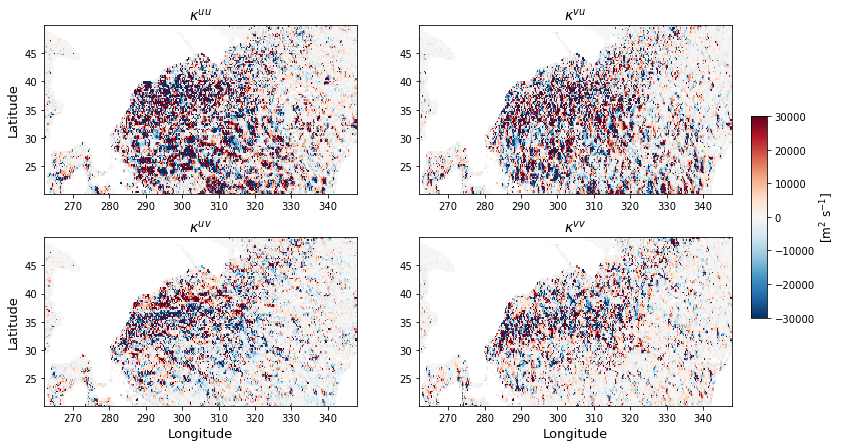

1097280
YC = 19.91670036315918
Lapse time: 1641.0474853515625
YC = 27.416702270507812
Lapse time: 1770.6119136810303
YC = 34.91670227050781
Lapse time: 1688.3400838375092
YC = 42.41670227050781
Lapse time: 1556.2910528182983
YC = 49.91670227050781
Lapse time: 64.4133038520813
1099440
YC = 19.91670036315918
Lapse time: 1552.2314140796661
YC = 27.416702270507812
Lapse time: 1604.1496663093567
YC = 34.91670227050781


In [ ]:
# ntimes = np.arange(943920,943920+dnf,dnf,dtype=int)
ntimes = np.arange(1095120+dnf,1101600+dnf,dnf,dtype=int)
# ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
for itime in ntimes:
    
    dsfx = xr.open_dataset(op.join(ddir,
                                   '%4d/Normalized-fluxes_isig%2d-%2d_Hann_no-smoothness_%010d.nc' 
                           % (year,sstart,send-1,itime)))
    ut_norm = dsfx.uptp
    vt_norm = dsfx.vptp
    us_norm = dsfx.upsp
    vs_norm = dsfx.vpsp
    uPV_norm = dsfx.upPVp
    vPV_norm = dsfx.vpPVp
    tx_norm = dsfx.tx
    ty_norm = dsfx.ty
    sx_norm = dsfx.sx
    sy_norm = dsfx.sy
    PVx_norm = dsfx.PVx
    PVy_norm = dsfx.PVy

    
##############################
##############################
    K = xr.DataArray(np.ones((len(dsfx.sig[::nbskip]),
                              len(dsfx.YC.sel(YC=slice(yNstart+5-12**-1,
                                                       yend+12**-1))[::nhskip]),
                              len(dsfx.XC[::nhskip]),2,2))*np.nan,
                     dims=['sig','YC','XC','row','col'],
                     coords={'sig':dsfx.sig[::nbskip].data,
                             'YC':dsfx.YC.sel(YC=slice(yNstart+5-12**-1,
                                                       yend+12**-1))[::nhskip].data,
                             'XC':dsfx.XC[::nhskip].data}
                    )

    for y in dsfx.YC.sel(YC=slice(yNstart+5-12**-1,yend+12**-1))[::nhskip][::nchk].data:
        print('YC =', y)
        start = time.time()

        for x in dsfx.XC[::nhskip][::nchk].data:
            F = xr.DataArray(np.array([[ ut_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                     XC=slice(x,x+nhskip*nchk*12**-1)
                                                    )[::nhskip,::nhskip,::nbskip], 
                                         vt_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                     XC=slice(x,x+nhskip*nchk*12**-1)
                                                    )[::nhskip,::nhskip,::nbskip]],
                                       [ us_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                     XC=slice(x,x+nhskip*nchk*12**-1)
                                                    )[::nhskip,::nhskip,::nbskip], 
                                         vs_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                     XC=slice(x,x+nhskip*nchk*12**-1)
                                                    )[::nhskip,::nhskip,::nbskip]],
                                       [uPV_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                     XC=slice(x,x+nhskip*nchk*12**-1)
                                                    )[::nhskip,::nhskip,::nbskip],
                                        vPV_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                     XC=slice(x,x+nhskip*nchk*12**-1)
                                                    )[::nhskip,::nhskip,::nbskip]]
                                      ]),
                             dims=['row','col','YC','XC','sig']
                            ).transpose('sig','YC','XC','row','col'
                                       ).chunk({'sig':1,'YC':1,'XC':1})

            G = xr.DataArray(np.array([[ -tx_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                      XC=slice(x,x+nhskip*nchk*12**-1)
                                                     )[::nhskip,::nhskip,::nbskip], 
                                         -ty_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                      XC=slice(x,x+nhskip*nchk*12**-1)
                                                     )[::nhskip,::nhskip,::nbskip]],
                                       [ -sx_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                      XC=slice(x,x+nhskip*nchk*12**-1)
                                                     )[::nhskip,::nhskip,::nbskip], 
                                         -sy_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                      XC=slice(x,x+nhskip*nchk*12**-1)
                                                     )[::nhskip,::nhskip,::nbskip]],
                                       [-PVx_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                      XC=slice(x,x+nhskip*nchk*12**-1)
                                                     )[::nhskip,::nhskip,::nbskip],
                                        -PVy_norm.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                                                      XC=slice(x,x+nhskip*nchk*12**-1)
                                                     )[::nhskip,::nhskip,::nbskip]]
                                       ]),
                             dims=['row','col','YC','XC','sig']
                            ).chunk({'sig':1,'YC':1,'XC':1}
                                   ).transpose('sig','YC','XC','row','col')

            invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, G.data).compute(),
                                dims=['sig','YC','XC','row','col'],
                               ).chunk({'sig':1,'YC':1,'XC':1})

 
            K.sel(YC=slice(y,y+nhskip*nchk*12**-1),
                  XC=slice(x,x+nhskip*nchk*12**-1)
                 )[:] = dsar.map_blocks(_dot, invG.data, F.data,
                                        chunks=(1,1,1,2,2)).compute()

        end = time.time()
        print('Lapse time:', end-start)

    K.to_dataset(name='K').to_netcdf(op.join(ddir,
                                     '%4d/Diff-tensor_isig%2d-%2d_nskip%1d_%010d_Hann_no-smoothness.nc' 
                                     % (year,sstart,send-1,nhskip,itime)))

##############################
    if itime == ntimes[0]:
        fig, axes = plt.subplots(figsize=(13,7), nrows=2, ncols=2)
        im0 = axes[0,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                                   K.isel(sig=2)[:,:,0,0].sel(YC=slice(yNstart+5,yend)), 
                                   vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
        im1 = axes[0,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                                   K.isel(sig=2)[:,:,0,1].sel(YC=slice(yNstart+5,yend)), 
                                   vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
        im2 = axes[1,0].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)),
                                   K.isel(sig=2)[:,:,1,0].sel(YC=slice(yNstart+5,yend)), 
                                   vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
        im3 = axes[1,1].pcolormesh(K.XC, K.YC.sel(YC=slice(yNstart+5,yend)), 
                                   K.isel(sig=2)[:,:,1,1].sel(YC=slice(yNstart+5,yend)), 
                                   vmin=-3e4, vmax=3e4, cmap='RdBu_r', rasterized=True)
        axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
        axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
        axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
        axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)
        axes[1,0].set_xlabel(r"Longitude", fontsize=13)
        axes[1,1].set_xlabel(r"Longitude", fontsize=13)
        axes[0,0].set_ylabel(r"Latitude", fontsize=13)
        axes[1,0].set_ylabel(r"Latitude", fontsize=13)
        fig.subplots_adjust(right=0.86, hspace=.26) 
        cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
        cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0)
        cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
        plt.show()
        plt.savefig(op.join(ddir,'Figures/Kappas_isig17_%4d-%010d_Hann_no-smoothness.pdf'
                            % (year,itime)))
        
        
    del K
    dsfx.close()
    
    print(itime)